In [2]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 37.6MB 144kB/s 
     |████████████████████████████████| 952kB 41.7MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!pip install timm

     |████████████████████████████████| 296kB 4.4MB/s 


# Dataset

In [3]:
cd drive/MyDrive/pet_sber/

/content/drive/MyDrive/pet_sber


In [4]:
ls

dataset/  experiments/  imagewoof2.tgz  noisy_imagewoof.csv


In [5]:
# !mkdir dataset

In [6]:
# !mkdir experiments

In [7]:
# !tar -zxvf imagewoof2.tgz -C dataset

In [8]:
!apt-get -q install tree

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (111 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [9]:
!tree -d .

.
├── dataset
│   └── imagewoof2
│       ├── train
│       │   ├── n02086240
│       │   ├── n02087394
│       │   ├── n02088364
│       │   ├── n02089973
│       │   ├── n02093754
│       │   ├── n02096294
│       │   ├── n02099601
│       │   ├── n02105641
│       │   ├── n02111889
│       │   └── n02115641
│       └── val
│           ├── n02086240
│           ├── n02087394
│           ├── n02088364
│           ├── n02089973
│           ├── n02093754
│           ├── n02096294
│           ├── n02099601
│           ├── n02105641
│           ├── n02111889
│           └── n02115641
└── experiments

25 directories


In [10]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import time

In [12]:
class config:
    experiments_folder = os.path.abspath("/content/drive/MyDrive/pet_sber/experiments")
    current_working_folder = os.path.abspath(f'{experiments_folder}/exp_{len(os.listdir(experiments_folder))}/')
    data_path = os.path.abspath('/content/drive/MyDrive/pet_sber/dataset/imagewoof2')
    df_path = os.path.join(data_path, 'noisy_imagewoof.csv')
    im_size = 512
    seed = 42
    lr = 0.0001
    min_lr = 1e-6
    weight_decay = 1e-6
    num_workers = 2
    verbose_step = 1
    device =  'cuda:0' 
    train_batch_size = 4
    valid_batch_size = 4
    n_epochs = 100
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    OptimizerClass = torch.optim.AdamW
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
         mode='max',
         factor=0.5,
         patience=5,
         verbose=True, 
         threshold=0.0001,
         threshold_mode='abs',
         cooldown=0, 
         min_lr=1e-8,
         eps=1e-08
     )

In [13]:
df = pd.read_csv(config.df_path)
df.head()

path  ... is_valid
0   train/n02115641/n02115641_3995.JPEG  ...    False
1    train/n02115641/n02115641_843.JPEG  ...    False
2   train/n02115641/n02115641_2953.JPEG  ...    False
3   train/n02115641/n02115641_6458.JPEG  ...    False
4  train/n02115641/n02115641_19414.JPEG  ...    False

[5 rows x 7 columns]

In [14]:
label2idx = {k:i for i, k in enumerate(df['noisy_labels_0'].unique())}
label2idx

{'n02086240': 1,
 'n02087394': 3,
 'n02088364': 2,
 'n02089973': 9,
 'n02093754': 8,
 'n02096294': 7,
 'n02099601': 6,
 'n02105641': 4,
 'n02111889': 5,
 'n02115641': 0}

In [15]:
idx2label = {i:k for k, i in label2idx.items()}
idx2label

{0: 'n02115641',
 1: 'n02086240',
 2: 'n02088364',
 3: 'n02087394',
 4: 'n02105641',
 5: 'n02111889',
 6: 'n02099601',
 7: 'n02096294',
 8: 'n02093754',
 9: 'n02089973'}

In [16]:
df['class_id'] = df['noisy_labels_0'].map(label2idx)
df.head()

path noisy_labels_0  ... is_valid class_id
0   train/n02115641/n02115641_3995.JPEG      n02115641  ...    False        0
1    train/n02115641/n02115641_843.JPEG      n02115641  ...    False        0
2   train/n02115641/n02115641_2953.JPEG      n02115641  ...    False        0
3   train/n02115641/n02115641_6458.JPEG      n02115641  ...    False        0
4  train/n02115641/n02115641_19414.JPEG      n02115641  ...    False        0

[5 rows x 8 columns]

In [17]:
df.groupby('class_id').size()

class_id
0    1350
1    1350
2    1350
3    1350
4    1350
5    1350
6    1350
7    1350
8    1350
9     804
dtype: int64

In [18]:
df.groupby('is_valid').size()

is_valid
False    9025
True     3929
dtype: int64

In [19]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A

In [20]:
class DogBreedsDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame,
        image_folder: os.path,
        transform: A.Compose or None):

        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.image_folder,
                                self.df.loc[idx, 'path'])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.df.loc[idx, 'class_id']
        
        if self.transform:
            transformed = self.transform(image=image, 
                                         label=label)
            image = transformed['image']
            label = torch.tensor(transformed['label'])

        sample = {'image': image,  
                  'label': label}

        return sample

In [21]:
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
        A.OneOf(
            [
                A.RandomResizedCrop(config.im_size, config.im_size, p=0.5),
                A.Resize(config.im_size, config.im_size, p=0.5),
            ], p=1.
        ),
        A.HorizontalFlip(),
        A.VerticalFlip(), 
        A.ShiftScaleRotate(p=0.5),
        A.Cutout(num_holes=16, max_h_size=32, max_w_size=32, p=0.5),
        A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5)
        ]),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])

valid_transforms = A.Compose([
        A.Resize(config.im_size, config.im_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
    ])

In [22]:
train_dataset = DogBreedsDataset(df[df['is_valid']!=True], 
                                config.data_path,
                                train_transforms)
valid_dataset = DogBreedsDataset(df[df['is_valid']==True], 
                                config.data_path, 
                                valid_transforms)

In [23]:
train_loader = DataLoader(train_dataset, 
                          batch_size=config.train_batch_size, 
                          shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=config.valid_batch_size, 
                          shuffle=False, drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


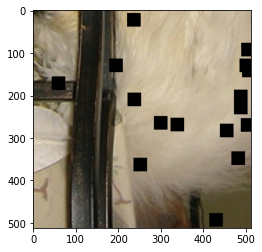

In [24]:
temp_img = next(iter(train_loader))['image'][0].permute(1, 2, 0).numpy()
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
temp_img = (temp_img*std+mean)
plt.imshow(temp_img)

## Model

In [25]:
import timm
import torch
from torch import nn

In [26]:
class DogBreedsModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()

        self.model = timm.create_model(model_arch, pretrained=pretrained)
        in_features = self.model.fc.in_features

        layers_without_classifier = list(self.model.children())[:-2]
        additional_layers = [nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()]
        self.model = nn.Sequential(*(layers_without_classifier+additional_layers))

        self.classif_head = nn.Linear(in_features, n_class)



    def forward(self, x):
        x = self.model(x)
        label = self.classif_head(x)

        return label


In [27]:
model = DogBreedsModel('resnet50', n_class=len(idx2label), pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [28]:
model.to(config.device)

DogBreedsModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act3): ReLU

## Fitter

In [50]:
from torch.nn import CrossEntropyLoss
from tqdm.notebook import tqdm, trange
from datetime import datetime
import copy
from sklearn.metrics import accuracy_score, f1_score


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.base_dir = f'{config.current_working_folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_acc = -1
        self.best_summary_f1 = -1
        self.model = model
        self.device = device

        self.criterion = CrossEntropyLoss()
        param_optimizer = list(self.model.named_parameters())

        self.optimizer = config.OptimizerClass(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        history_dict = {}

        history_dict['epoch'] = []
        history_dict['train_loss'] = []
        history_dict['val_loss'] = []
        history_dict['train_lr'] = []
        history_dict['val_accuracy'] = []
        history_dict['val_f1'] = []

        tr = trange(self.epoch, self.config.n_epochs)
        for e in tr:
            history_dict['epoch'].append(self.epoch)
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            
            if self.config.verbose:
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            train_loss, loss_trend, lr_trend = self.train_epoch(train_loader)
            
            history_dict['train_loss'].append(loss_trend)
            history_dict['train_lr'].append(lr_trend)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {train_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            val_loss, loss_trend, val_acc, acc_trend, val_f1 = self.validation(validation_loader)
            history_dict['val_loss'].append(loss_trend)
            history_dict['val_accuracy'].append(acc_trend)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {val_loss.avg:.5f}, summary_acc: {val_acc.avg:.5f}, summary_f1: {val_f1.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if val_f1.avg > self.best_summary_f1:
                self.best_summary_f1 = val_f1.avg
                self.model.eval()
                checkpoint_name = f'{self.base_dir}/fold_{self.config.fold}_best-checkpoint-{str(self.epoch).zfill(3)}epoch_f1={val_f1.avg:.3f}.bin'
                self.save(checkpoint_name)
                
                try:
                    os.remove(f)
                except:pass
                f = copy.deepcopy(checkpoint_name)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=val_f1.avg)

            self.epoch += 1

        
        plt.figure(figsize=(15, 10))
        plt.plot([np.mean(i) for i in history_dict['train_loss']], label = 'train_loss')
        plt.plot([np.mean(i) for i in history_dict['val_loss']], label = 'val_loss')
        plt.plot([np.mean(i) for i in history_dict['val_accuracy']], label = 'val_accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss/Accuracy')
        plt.legend()
        plt.savefig(os.path.split(self.log_path)[0]+f'/metrics.jpg')

        return history_dict

    def train_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
        lr_trend = []
        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )            
            images = batch['image']
            labels = batch['label']

            images = images.to(self.device).float()
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output.float(), labels)
            loss.backward()
            summary_loss.update(loss.detach().item(), self.config.train_batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

            
            lr = self.optimizer.param_groups[0]['lr']
            loss_trend.append(summary_loss.avg)
            lr_trend.append(lr)
        return summary_loss, loss_trend, lr_trend
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        summary_acc = AverageMeter()
        summary_f1 = AverageMeter()
        t = time.time()
        loss_trend = []
        acc_trend = []
        all_labels = []
        all_preds = []
        num_preds = 0
        for step, batch in tqdm(enumerate(val_loader), total=len(val_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            with torch.no_grad():

                images = batch['image']
                labels = batch['label']

                images = images.to(self.device).float()
                labels = labels.to(self.device)

                output = self.model(images)

                
                loss = self.criterion(output.float(), labels)
                summary_loss.update(loss.detach().item(), self.config.valid_batch_size)

                current_acc = accuracy_score(labels.cpu().numpy(), output.argmax(axis=1).cpu().numpy())
                summary_acc.update(current_acc, self.config.valid_batch_size)

                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(output.argmax(axis=1).cpu().numpy())
                

                loss_trend.append(summary_loss.avg)
                acc_trend.append(summary_acc.avg)

        f1 = f1_score(all_labels, all_preds, average='macro')
        summary_f1.update(f1, len(val_loader))

        return summary_loss, loss_trend, summary_acc, acc_trend, summary_f1
    
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_accuracy': self.best_summary_acc,
            'best_summary_f1': self.best_summary_f1,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_acc = checkpoint['best_summary_accuracy']
        self.best_summary_f1 = checkpoint['best_summary_f1']
        self.epoch = checkpoint['epoch'] + 1
        self.base_dir = path.split(path)[0]
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [51]:
fitter = Fitter(model=model, device=config.device, config=config)
history_dict = fitter.fit(train_loader, valid_loader)

Fitter prepared. Device is cuda:0



2021-04-19T20:42:06.226849
LR: 0.0001


Train Step 2255/2256, summary_loss: 1.00464, time: 476.92448
[RESULT]: Train. Epoch: 0, summary_loss: 1.00447, time: 477.06886


Val Step 982/983, summary_loss: 0.83828, time: 91.05062
[RESULT]: Val. Epoch: 0, summary_loss: 0.83744, summary_acc: 0.77848, summary_f1: 0.77564, time: 91.07838

2021-04-19T20:51:36.404993
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.88460, time: 476.70131
[RESULT]: Train. Epoch: 1, summary_loss: 0.88425, time: 476.84397


Val Step 982/983, summary_loss: 0.55663, time: 90.20827
[RESULT]: Val. Epoch: 1, summary_loss: 0.55634, summary_acc: 0.82960, summary_f1: 0.82221, time: 90.23587

2021-04-19T21:01:06.609629
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.81794, time: 474.69021
[RESULT]: Train. Epoch: 2, summary_loss: 0.81787, time: 474.83121


Val Step 982/983, summary_loss: 0.44438, time: 90.18622
[RESULT]: Val. Epoch: 2, summary_loss: 0.44411, summary_acc: 0.86750, summary_f1: 0.85970, time: 90.21567

2021-04-19T21:10:33.773943
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.75762, time: 474.66385
[RESULT]: Train. Epoch: 3, summary_loss: 0.75741, time: 474.80789


Val Step 982/983, summary_loss: 0.55513, time: 90.55125
[RESULT]: Val. Epoch: 3, summary_loss: 0.55458, summary_acc: 0.83520, summary_f1: 0.83000, time: 90.58054

2021-04-19T21:20:00.238365
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.72210, time: 475.01392
[RESULT]: Train. Epoch: 4, summary_loss: 0.72211, time: 475.15447


Val Step 982/983, summary_loss: 0.47330, time: 90.66446
[RESULT]: Val. Epoch: 4, summary_loss: 0.47286, summary_acc: 0.85834, summary_f1: 0.85156, time: 90.69157

2021-04-19T21:29:27.156415
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.67544, time: 478.73332
[RESULT]: Train. Epoch: 5, summary_loss: 0.67526, time: 478.87597


Val Step 982/983, summary_loss: 0.45272, time: 90.88612
[RESULT]: Val. Epoch: 5, summary_loss: 0.45227, summary_acc: 0.86165, summary_f1: 0.85521, time: 90.91314

2021-04-19T21:38:58.040455
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.65510, time: 475.06519
[RESULT]: Train. Epoch: 6, summary_loss: 0.65487, time: 475.20857


Val Step 982/983, summary_loss: 0.52843, time: 91.01207
[RESULT]: Val. Epoch: 6, summary_loss: 0.52792, summary_acc: 0.84944, summary_f1: 0.83905, time: 91.04129

2021-04-19T21:48:25.396352
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.63330, time: 475.73160
[RESULT]: Train. Epoch: 7, summary_loss: 0.63337, time: 475.87772


Val Step 982/983, summary_loss: 0.46372, time: 90.45819
[RESULT]: Val. Epoch: 7, summary_loss: 0.46328, summary_acc: 0.85987, summary_f1: 0.85343, time: 90.48829

2021-04-19T21:57:52.816750
LR: 0.0001


Train Step 2255/2256, summary_loss: 0.63762, time: 475.83615
[RESULT]: Train. Epoch: 8, summary_loss: 0.63754, time: 475.98086


Val Step 982/983, summary_loss: 0.45758, time: 90.64589
[RESULT]: Val. Epoch: 8, summary_loss: 0.45716, summary_acc: 0.86623, summary_f1: 0.85598, time: 90.67500
Epoch     9: reducing learning rate of group 0 to 5.0000e-05.

2021-04-19T22:07:20.509347
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.48341, time: 476.06194
[RESULT]: Train. Epoch: 9, summary_loss: 0.48346, time: 476.20680


Val Step 982/983, summary_loss: 0.33656, time: 90.61077
[RESULT]: Val. Epoch: 9, summary_loss: 0.33627, summary_acc: 0.90514, summary_f1: 0.89452, time: 90.63907

2021-04-19T22:16:49.482750
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.46478, time: 475.97490
[RESULT]: Train. Epoch: 10, summary_loss: 0.46469, time: 476.11523


Val Step 982/983, summary_loss: 0.34817, time: 90.87684
[RESULT]: Val. Epoch: 10, summary_loss: 0.34782, summary_acc: 0.89852, summary_f1: 0.89220, time: 90.90443

2021-04-19T22:26:17.554828
LR: 5e-05



[RESULT]: Train. Epoch: 11, summary_loss: 0.44131, time: 475.67823


Val Step 982/983, summary_loss: 0.35982, time: 90.92186
[RESULT]: Val. Epoch: 11, summary_loss: 0.35952, summary_acc: 0.89903, summary_f1: 0.88619, time: 90.95261

2021-04-19T22:35:45.259848
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.42779, time: 475.28351
[RESULT]: Train. Epoch: 12, summary_loss: 0.42773, time: 475.42682


Val Step 982/983, summary_loss: 0.33735, time: 90.01564
[RESULT]: Val. Epoch: 12, summary_loss: 0.33702, summary_acc: 0.90005, summary_f1: 0.89382, time: 90.04867

2021-04-19T22:45:11.830379
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.41704, time: 476.14817
[RESULT]: Train. Epoch: 13, summary_loss: 0.41744, time: 476.29034


Val Step 982/983, summary_loss: 0.36556, time: 90.93581
[RESULT]: Val. Epoch: 13, summary_loss: 0.36519, summary_acc: 0.90132, summary_f1: 0.89542, time: 90.96492

2021-04-19T22:54:41.257636
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.40560, time: 477.50505
[RESULT]: Train. Epoch: 14, summary_loss: 0.40550, time: 477.64751


Val Step 982/983, summary_loss: 0.32639, time: 90.99888
[RESULT]: Val. Epoch: 14, summary_loss: 0.32607, summary_acc: 0.91175, summary_f1: 0.90581, time: 91.02754

2021-04-19T23:04:12.048451
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.38818, time: 476.22254
[RESULT]: Train. Epoch: 15, summary_loss: 0.38861, time: 476.36466


Val Step 982/983, summary_loss: 0.35035, time: 90.59207
[RESULT]: Val. Epoch: 15, summary_loss: 0.34999, summary_acc: 0.90259, summary_f1: 0.89467, time: 90.61929

2021-04-19T23:13:40.110623
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.38732, time: 476.51075
[RESULT]: Train. Epoch: 16, summary_loss: 0.38715, time: 476.65117


Val Step 982/983, summary_loss: 0.35971, time: 90.71370
[RESULT]: Val. Epoch: 16, summary_loss: 0.35937, summary_acc: 0.90132, summary_f1: 0.89046, time: 90.74371

2021-04-19T23:23:08.557803
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.37521, time: 476.94815
[RESULT]: Train. Epoch: 17, summary_loss: 0.37505, time: 477.09014


Val Step 982/983, summary_loss: 0.36351, time: 90.28303
[RESULT]: Val. Epoch: 17, summary_loss: 0.36315, summary_acc: 0.89980, summary_f1: 0.89402, time: 90.31256

2021-04-19T23:32:37.037603
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.36684, time: 478.12261
[RESULT]: Train. Epoch: 18, summary_loss: 0.36669, time: 478.26492


Val Step 982/983, summary_loss: 0.32790, time: 91.02070
[RESULT]: Val. Epoch: 18, summary_loss: 0.32757, summary_acc: 0.90488, summary_f1: 0.89948, time: 91.05029

2021-04-19T23:42:07.414973
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.36427, time: 476.42531
[RESULT]: Train. Epoch: 19, summary_loss: 0.36424, time: 476.56589


Val Step 982/983, summary_loss: 0.33718, time: 91.59437
[RESULT]: Val. Epoch: 19, summary_loss: 0.33684, summary_acc: 0.90743, summary_f1: 0.89964, time: 91.62388

2021-04-19T23:51:36.734692
LR: 5e-05


Train Step 2255/2256, summary_loss: 0.35130, time: 477.74691
[RESULT]: Train. Epoch: 20, summary_loss: 0.35136, time: 477.88899


Val Step 982/983, summary_loss: 0.35461, time: 90.99253
[RESULT]: Val. Epoch: 20, summary_loss: 0.35426, summary_acc: 0.90259, summary_f1: 0.89635, time: 91.02322
Epoch    21: reducing learning rate of group 0 to 2.5000e-05.

2021-04-20T00:01:06.753860
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.30128, time: 477.43635
[RESULT]: Train. Epoch: 21, summary_loss: 0.30150, time: 477.57693


Val Step 982/983, summary_loss: 0.30859, time: 90.58200
[RESULT]: Val. Epoch: 21, summary_loss: 0.30828, summary_acc: 0.91633, summary_f1: 0.90929, time: 90.61199

2021-04-20T00:10:37.043086
LR: 2.5e-05



[RESULT]: Train. Epoch: 22, summary_loss: 0.28918, time: 477.60520


Val Step 982/983, summary_loss: 0.32397, time: 91.00586
[RESULT]: Val. Epoch: 22, summary_loss: 0.32364, summary_acc: 0.91480, summary_f1: 0.90738, time: 91.03514

2021-04-20T00:20:06.759163
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.28550, time: 477.72775
[RESULT]: Train. Epoch: 23, summary_loss: 0.28556, time: 477.86862


Val Step 982/983, summary_loss: 0.32013, time: 90.91014
[RESULT]: Val. Epoch: 23, summary_loss: 0.31981, summary_acc: 0.91480, summary_f1: 0.90824, time: 90.94093

2021-04-20T00:29:36.620121
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.28275, time: 477.50162
[RESULT]: Train. Epoch: 24, summary_loss: 0.28320, time: 477.64643


Val Step 982/983, summary_loss: 0.30233, time: 90.67270
[RESULT]: Val. Epoch: 24, summary_loss: 0.30203, summary_acc: 0.91607, summary_f1: 0.91019, time: 90.70009

2021-04-20T00:39:07.033811
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.27491, time: 477.09673
[RESULT]: Train. Epoch: 25, summary_loss: 0.27488, time: 477.24101


Val Step 982/983, summary_loss: 0.31892, time: 90.67442
[RESULT]: Val. Epoch: 25, summary_loss: 0.31860, summary_acc: 0.91556, summary_f1: 0.90873, time: 90.70454

2021-04-20T00:48:36.107441
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.27218, time: 476.58042
[RESULT]: Train. Epoch: 26, summary_loss: 0.27207, time: 476.72158


Val Step 982/983, summary_loss: 0.31909, time: 91.15131
[RESULT]: Val. Epoch: 26, summary_loss: 0.31877, summary_acc: 0.91734, summary_f1: 0.91023, time: 91.18143

2021-04-20T00:58:06.110965
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.23756, time: 477.07525
[RESULT]: Train. Epoch: 27, summary_loss: 0.23787, time: 477.21839


Val Step 982/983, summary_loss: 0.31278, time: 90.99159
[RESULT]: Val. Epoch: 27, summary_loss: 0.31247, summary_acc: 0.91734, summary_f1: 0.91065, time: 91.02226

2021-04-20T01:07:36.506693
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.27146, time: 477.74397
[RESULT]: Train. Epoch: 28, summary_loss: 0.27135, time: 477.88894


Val Step 982/983, summary_loss: 0.31024, time: 90.67830
[RESULT]: Val. Epoch: 28, summary_loss: 0.30993, summary_acc: 0.91989, summary_f1: 0.91428, time: 90.70629

2021-04-20T01:17:07.191918
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.26206, time: 473.71189
[RESULT]: Train. Epoch: 29, summary_loss: 0.26197, time: 473.85082


Val Step 982/983, summary_loss: 0.30400, time: 88.78968
[RESULT]: Val. Epoch: 29, summary_loss: 0.30370, summary_acc: 0.91811, summary_f1: 0.91240, time: 88.81762

2021-04-20T01:26:30.971122
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.24770, time: 471.01295
[RESULT]: Train. Epoch: 30, summary_loss: 0.24775, time: 471.15383


Val Step 982/983, summary_loss: 0.29653, time: 89.04349
[RESULT]: Val. Epoch: 30, summary_loss: 0.29623, summary_acc: 0.92294, summary_f1: 0.91658, time: 89.07357

2021-04-20T01:35:54.259071
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.25114, time: 474.87007
[RESULT]: Train. Epoch: 31, summary_loss: 0.25103, time: 475.01107


Val Step 982/983, summary_loss: 0.32036, time: 89.36884
[RESULT]: Val. Epoch: 31, summary_loss: 0.32004, summary_acc: 0.91913, summary_f1: 0.91325, time: 89.39952

2021-04-20T01:45:19.783479
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.24547, time: 478.19323
[RESULT]: Train. Epoch: 32, summary_loss: 0.24539, time: 478.33453


Val Step 982/983, summary_loss: 0.31632, time: 91.32914
[RESULT]: Val. Epoch: 32, summary_loss: 0.31600, summary_acc: 0.92040, summary_f1: 0.91463, time: 91.35717

2021-04-20T01:54:50.568358
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.23941, time: 479.53188
[RESULT]: Train. Epoch: 33, summary_loss: 0.23983, time: 479.67540


Val Step 982/983, summary_loss: 0.31574, time: 90.80873
[RESULT]: Val. Epoch: 33, summary_loss: 0.31541, summary_acc: 0.91963, summary_f1: 0.91328, time: 90.83744

2021-04-20T02:04:22.185545
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.23448, time: 480.81772
[RESULT]: Train. Epoch: 34, summary_loss: 0.23444, time: 480.96321


Val Step 982/983, summary_loss: 0.34109, time: 90.97348
[RESULT]: Val. Epoch: 34, summary_loss: 0.34074, summary_acc: 0.91582, summary_f1: 0.90974, time: 91.00314

2021-04-20T02:13:55.229623
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.24038, time: 481.06546
[RESULT]: Train. Epoch: 35, summary_loss: 0.24049, time: 481.20773


Val Step 982/983, summary_loss: 0.32563, time: 90.62187
[RESULT]: Val. Epoch: 35, summary_loss: 0.32530, summary_acc: 0.92014, summary_f1: 0.91513, time: 90.65042

2021-04-20T02:23:29.198358
LR: 2.5e-05


Train Step 2255/2256, summary_loss: 0.23826, time: 480.33436
[RESULT]: Train. Epoch: 36, summary_loss: 0.23819, time: 480.47592


Val Step 982/983, summary_loss: 0.31576, time: 90.52667
[RESULT]: Val. Epoch: 36, summary_loss: 0.31544, summary_acc: 0.92014, summary_f1: 0.91400, time: 90.55586
Epoch    37: reducing learning rate of group 0 to 1.2500e-05.

2021-04-20T02:33:01.398352
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.21420, time: 481.53738
[RESULT]: Train. Epoch: 37, summary_loss: 0.21445, time: 481.68132


Val Step 982/983, summary_loss: 0.30571, time: 91.71288
[RESULT]: Val. Epoch: 37, summary_loss: 0.30540, summary_acc: 0.92116, summary_f1: 0.91562, time: 91.74361

2021-04-20T02:42:35.909609
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.20503, time: 481.11636
[RESULT]: Train. Epoch: 38, summary_loss: 0.20506, time: 481.25913


Val Step 982/983, summary_loss: 0.30666, time: 91.21284
[RESULT]: Val. Epoch: 38, summary_loss: 0.30635, summary_acc: 0.92447, summary_f1: 0.91889, time: 91.24503

2021-04-20T02:52:10.520304
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.20850, time: 479.91334
[RESULT]: Train. Epoch: 39, summary_loss: 0.20843, time: 480.05655


Val Step 982/983, summary_loss: 0.28868, time: 89.53809
[RESULT]: Val. Epoch: 39, summary_loss: 0.28838, summary_acc: 0.92701, summary_f1: 0.92097, time: 89.56703

2021-04-20T03:01:42.255850
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.19214, time: 477.12531
[RESULT]: Train. Epoch: 40, summary_loss: 0.19214, time: 477.26863


Val Step 982/983, summary_loss: 0.31818, time: 90.31732
[RESULT]: Val. Epoch: 40, summary_loss: 0.31786, summary_acc: 0.92599, summary_f1: 0.91868, time: 90.34760

2021-04-20T03:11:10.965660
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.20094, time: 478.43885
[RESULT]: Train. Epoch: 41, summary_loss: 0.20085, time: 478.58089


Val Step 982/983, summary_loss: 0.30544, time: 90.31288
[RESULT]: Val. Epoch: 41, summary_loss: 0.30513, summary_acc: 0.92803, summary_f1: 0.92235, time: 90.34147

2021-04-20T03:20:41.969270
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.18482, time: 479.21088
[RESULT]: Train. Epoch: 42, summary_loss: 0.18503, time: 479.35405


Val Step 982/983, summary_loss: 0.30923, time: 90.57876
[RESULT]: Val. Epoch: 42, summary_loss: 0.30891, summary_acc: 0.92599, summary_f1: 0.92039, time: 90.60818

2021-04-20T03:30:13.004658
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.19384, time: 476.13421
[RESULT]: Train. Epoch: 43, summary_loss: 0.19380, time: 476.27917


Val Step 982/983, summary_loss: 0.31914, time: 92.96345
[RESULT]: Val. Epoch: 43, summary_loss: 0.31882, summary_acc: 0.92523, summary_f1: 0.91882, time: 92.99547

2021-04-20T03:39:43.464924
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.18795, time: 483.44990
[RESULT]: Train. Epoch: 44, summary_loss: 0.18786, time: 483.59192


Val Step 982/983, summary_loss: 0.30160, time: 92.02626
[RESULT]: Val. Epoch: 44, summary_loss: 0.30130, summary_acc: 0.92447, summary_f1: 0.91941, time: 92.05564

2021-04-20T03:49:20.205883
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.20140, time: 484.86469
[RESULT]: Train. Epoch: 45, summary_loss: 0.20138, time: 485.01045


Val Step 982/983, summary_loss: 0.30750, time: 91.97795
[RESULT]: Val. Epoch: 45, summary_loss: 0.30718, summary_acc: 0.92472, summary_f1: 0.91930, time: 92.00912

2021-04-20T03:58:58.324579
LR: 1.25e-05


Train Step 2255/2256, summary_loss: 0.17818, time: 484.67845
[RESULT]: Train. Epoch: 46, summary_loss: 0.17811, time: 484.81993


Val Step 982/983, summary_loss: 0.31934, time: 91.67709
[RESULT]: Val. Epoch: 46, summary_loss: 0.31901, summary_acc: 0.92752, summary_f1: 0.92129, time: 91.70603

2021-04-20T04:08:35.918576
LR: 1.25e-05



[RESULT]: Train. Epoch: 47, summary_loss: 0.18707, time: 484.67473


Val Step 982/983, summary_loss: 0.31812, time: 91.44496
[RESULT]: Val. Epoch: 47, summary_loss: 0.31780, summary_acc: 0.92421, summary_f1: 0.91832, time: 91.47168
Epoch    48: reducing learning rate of group 0 to 6.2500e-06.

2021-04-20T04:18:13.162269
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.17475, time: 481.70821
[RESULT]: Train. Epoch: 48, summary_loss: 0.17475, time: 481.85203


Val Step 982/983, summary_loss: 0.29859, time: 90.82541
[RESULT]: Val. Epoch: 48, summary_loss: 0.29829, summary_acc: 0.92803, summary_f1: 0.92177, time: 90.85450

2021-04-20T04:27:46.955482
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.17116, time: 484.60630
[RESULT]: Train. Epoch: 49, summary_loss: 0.17109, time: 484.75139


Val Step 982/983, summary_loss: 0.29798, time: 91.21803
[RESULT]: Val. Epoch: 49, summary_loss: 0.29768, summary_acc: 0.92650, summary_f1: 0.92042, time: 91.24622

2021-04-20T04:37:24.036349
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.16935, time: 483.89973
[RESULT]: Train. Epoch: 50, summary_loss: 0.16942, time: 484.04035


Val Step 982/983, summary_loss: 0.29122, time: 90.52158
[RESULT]: Val. Epoch: 50, summary_loss: 0.29092, summary_acc: 0.92370, summary_f1: 0.91749, time: 90.55139

2021-04-20T04:46:59.812601
LR: 6.25e-06



[RESULT]: Train. Epoch: 51, summary_loss: 0.17339, time: 480.03796


Val Step 982/983, summary_loss: 0.28166, time: 90.50425
[RESULT]: Val. Epoch: 51, summary_loss: 0.28137, summary_acc: 0.93184, summary_f1: 0.92571, time: 90.53177

2021-04-20T04:56:32.472948
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.16661, time: 481.33829
[RESULT]: Train. Epoch: 52, summary_loss: 0.16654, time: 481.48213


Val Step 982/983, summary_loss: 0.29306, time: 90.99296
[RESULT]: Val. Epoch: 52, summary_loss: 0.29277, summary_acc: 0.93133, summary_f1: 0.92571, time: 91.02224

2021-04-20T05:06:07.159446
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.17717, time: 482.47042
[RESULT]: Train. Epoch: 53, summary_loss: 0.17717, time: 482.61365


Val Step 982/983, summary_loss: 0.29415, time: 91.90760
[RESULT]: Val. Epoch: 53, summary_loss: 0.29385, summary_acc: 0.93006, summary_f1: 0.92418, time: 91.93760

2021-04-20T05:15:42.810910
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.16969, time: 481.62592
[RESULT]: Train. Epoch: 54, summary_loss: 0.17001, time: 481.77088


Val Step 982/983, summary_loss: 0.29223, time: 90.71296
[RESULT]: Val. Epoch: 54, summary_loss: 0.29193, summary_acc: 0.93082, summary_f1: 0.92452, time: 90.74088

2021-04-20T05:25:16.438988
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.16588, time: 477.70697
[RESULT]: Train. Epoch: 55, summary_loss: 0.16586, time: 477.84977


Val Step 982/983, summary_loss: 0.29858, time: 90.82097
[RESULT]: Val. Epoch: 55, summary_loss: 0.29828, summary_acc: 0.92650, summary_f1: 0.92069, time: 90.85370

2021-04-20T05:34:46.224309
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.16361, time: 476.59179
[RESULT]: Train. Epoch: 56, summary_loss: 0.16354, time: 476.73695


Val Step 982/983, summary_loss: 0.29643, time: 89.94324
[RESULT]: Val. Epoch: 56, summary_loss: 0.29613, summary_acc: 0.92879, summary_f1: 0.92354, time: 89.97256

2021-04-20T05:44:14.009549
LR: 6.25e-06


Train Step 2255/2256, summary_loss: 0.17232, time: 477.63103
[RESULT]: Train. Epoch: 57, summary_loss: 0.17224, time: 477.77588


Val Step 982/983, summary_loss: 0.29345, time: 91.57894
[RESULT]: Val. Epoch: 57, summary_loss: 0.29315, summary_acc: 0.92879, summary_f1: 0.92310, time: 91.60853
Epoch    58: reducing learning rate of group 0 to 3.1250e-06.

2021-04-20T05:53:44.487257
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15720, time: 480.27348
[RESULT]: Train. Epoch: 58, summary_loss: 0.15714, time: 480.41602


Val Step 982/983, summary_loss: 0.29920, time: 91.32107
[RESULT]: Val. Epoch: 58, summary_loss: 0.29890, summary_acc: 0.93006, summary_f1: 0.92455, time: 91.35018

2021-04-20T06:03:17.312129
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.16671, time: 480.35351
[RESULT]: Train. Epoch: 59, summary_loss: 0.16666, time: 480.49394


Val Step 982/983, summary_loss: 0.28836, time: 90.75444
[RESULT]: Val. Epoch: 59, summary_loss: 0.28806, summary_acc: 0.93108, summary_f1: 0.92559, time: 90.78313

2021-04-20T06:12:49.696721
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15909, time: 474.25691
[RESULT]: Train. Epoch: 60, summary_loss: 0.15902, time: 474.39789


Val Step 982/983, summary_loss: 0.29084, time: 89.49891
[RESULT]: Val. Epoch: 60, summary_loss: 0.29054, summary_acc: 0.93006, summary_f1: 0.92496, time: 89.52906

2021-04-20T06:22:14.700983
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.16123, time: 475.89096
[RESULT]: Train. Epoch: 61, summary_loss: 0.16133, time: 476.03220


Val Step 982/983, summary_loss: 0.28222, time: 91.02935
[RESULT]: Val. Epoch: 61, summary_loss: 0.28193, summary_acc: 0.93286, summary_f1: 0.92797, time: 91.05913

2021-04-20T06:31:43.860746
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.14900, time: 481.24438
[RESULT]: Train. Epoch: 62, summary_loss: 0.14895, time: 481.38490


Val Step 982/983, summary_loss: 0.29567, time: 90.74763
[RESULT]: Val. Epoch: 62, summary_loss: 0.29537, summary_acc: 0.92981, summary_f1: 0.92395, time: 90.77577

2021-04-20T06:41:17.116531
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15627, time: 475.87766
[RESULT]: Train. Epoch: 63, summary_loss: 0.15673, time: 476.01897


Val Step 982/983, summary_loss: 0.30629, time: 89.73725
[RESULT]: Val. Epoch: 63, summary_loss: 0.30598, summary_acc: 0.92904, summary_f1: 0.92254, time: 89.76647

2021-04-20T06:50:45.066285
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15817, time: 475.67516
[RESULT]: Train. Epoch: 64, summary_loss: 0.15811, time: 475.81578


Val Step 982/983, summary_loss: 0.30586, time: 91.12640
[RESULT]: Val. Epoch: 64, summary_loss: 0.30555, summary_acc: 0.92930, summary_f1: 0.92301, time: 91.15681

2021-04-20T07:00:13.130196
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15818, time: 476.05373
[RESULT]: Train. Epoch: 65, summary_loss: 0.15812, time: 476.19424


Val Step 982/983, summary_loss: 0.28080, time: 89.35054
[RESULT]: Val. Epoch: 65, summary_loss: 0.28052, summary_acc: 0.93286, summary_f1: 0.92775, time: 89.37875

2021-04-20T07:09:39.771253
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.14976, time: 474.13092
[RESULT]: Train. Epoch: 66, summary_loss: 0.14970, time: 474.27356


Val Step 982/983, summary_loss: 0.29166, time: 89.41785
[RESULT]: Val. Epoch: 66, summary_loss: 0.29137, summary_acc: 0.93032, summary_f1: 0.92480, time: 89.44678

2021-04-20T07:19:04.526917
LR: 3.125e-06


Train Step 2255/2256, summary_loss: 0.15212, time: 475.34263
[RESULT]: Train. Epoch: 67, summary_loss: 0.15230, time: 475.48467


Val Step 982/983, summary_loss: 0.30158, time: 93.26944
[RESULT]: Val. Epoch: 67, summary_loss: 0.30127, summary_acc: 0.93032, summary_f1: 0.92489, time: 93.29883
Epoch    68: reducing learning rate of group 0 to 1.5625e-06.

2021-04-20T07:28:34.386920
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14748, time: 489.06040
[RESULT]: Train. Epoch: 68, summary_loss: 0.14758, time: 489.20278


Val Step 982/983, summary_loss: 0.28318, time: 91.89552
[RESULT]: Val. Epoch: 68, summary_loss: 0.28289, summary_acc: 0.93260, summary_f1: 0.92753, time: 91.92850

2021-04-20T07:38:16.662930
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14711, time: 484.58065
[RESULT]: Train. Epoch: 69, summary_loss: 0.14726, time: 484.72280


Val Step 982/983, summary_loss: 0.28983, time: 91.70828
[RESULT]: Val. Epoch: 69, summary_loss: 0.28953, summary_acc: 0.93260, summary_f1: 0.92716, time: 91.73555

2021-04-20T07:47:54.257129
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14459, time: 480.95414
[RESULT]: Train. Epoch: 70, summary_loss: 0.14460, time: 481.09523


Val Step 982/983, summary_loss: 0.29633, time: 90.50237
[RESULT]: Val. Epoch: 70, summary_loss: 0.29603, summary_acc: 0.93032, summary_f1: 0.92486, time: 90.53386

2021-04-20T07:57:26.963697
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14562, time: 479.24176
[RESULT]: Train. Epoch: 71, summary_loss: 0.14557, time: 479.38388


Val Step 982/983, summary_loss: 0.28992, time: 90.09591
[RESULT]: Val. Epoch: 71, summary_loss: 0.28963, summary_acc: 0.93133, summary_f1: 0.92557, time: 90.12651

2021-04-20T08:06:57.591624
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14551, time: 479.22308
[RESULT]: Train. Epoch: 72, summary_loss: 0.14562, time: 479.36561


Val Step 982/983, summary_loss: 0.29216, time: 90.63901
[RESULT]: Val. Epoch: 72, summary_loss: 0.29187, summary_acc: 0.93286, summary_f1: 0.92747, time: 90.66756

2021-04-20T08:16:28.717113
LR: 1.5625e-06


Train Step 2255/2256, summary_loss: 0.14871, time: 477.92532
[RESULT]: Train. Epoch: 73, summary_loss: 0.14873, time: 478.06849


Val Step 982/983, summary_loss: 0.29603, time: 90.33175
[RESULT]: Val. Epoch: 73, summary_loss: 0.29573, summary_acc: 0.93210, summary_f1: 0.92618, time: 90.36235
Epoch    74: reducing learning rate of group 0 to 7.8125e-07.

2021-04-20T08:25:58.244336
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14566, time: 482.73958
[RESULT]: Train. Epoch: 74, summary_loss: 0.14560, time: 482.88218


Val Step 982/983, summary_loss: 0.28123, time: 91.71377
[RESULT]: Val. Epoch: 74, summary_loss: 0.28094, summary_acc: 0.93438, summary_f1: 0.92864, time: 91.74395

2021-04-20T08:35:35.061338
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14770, time: 487.35400
[RESULT]: Train. Epoch: 75, summary_loss: 0.14765, time: 487.49708


Val Step 982/983, summary_loss: 0.30075, time: 94.21040
[RESULT]: Val. Epoch: 75, summary_loss: 0.30045, summary_acc: 0.93057, summary_f1: 0.92435, time: 94.24095

2021-04-20T08:45:17.942361
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14617, time: 487.00917
[RESULT]: Train. Epoch: 76, summary_loss: 0.14617, time: 487.15384


Val Step 982/983, summary_loss: 0.28134, time: 93.18340
[RESULT]: Val. Epoch: 76, summary_loss: 0.28105, summary_acc: 0.93311, summary_f1: 0.92754, time: 93.21248

2021-04-20T08:54:59.460087
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14909, time: 479.41393
[RESULT]: Train. Epoch: 77, summary_loss: 0.14923, time: 479.55613


Val Step 982/983, summary_loss: 0.28133, time: 91.76512
[RESULT]: Val. Epoch: 77, summary_loss: 0.28104, summary_acc: 0.93337, summary_f1: 0.92759, time: 91.79393

2021-04-20T09:04:31.897016
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.13924, time: 489.10837
[RESULT]: Train. Epoch: 78, summary_loss: 0.13918, time: 489.25001


Val Step 982/983, summary_loss: 0.29111, time: 91.97740
[RESULT]: Val. Epoch: 78, summary_loss: 0.29082, summary_acc: 0.93133, summary_f1: 0.92563, time: 92.00874

2021-04-20T09:14:14.276095
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14177, time: 482.66117
[RESULT]: Train. Epoch: 79, summary_loss: 0.14172, time: 482.80217


Val Step 982/983, summary_loss: 0.28664, time: 90.77117
[RESULT]: Val. Epoch: 79, summary_loss: 0.28635, summary_acc: 0.93464, summary_f1: 0.92907, time: 90.79658

2021-04-20T09:23:50.036948
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14062, time: 481.78567
[RESULT]: Train. Epoch: 80, summary_loss: 0.14083, time: 481.92717


Val Step 982/983, summary_loss: 0.28705, time: 93.80326
[RESULT]: Val. Epoch: 80, summary_loss: 0.28676, summary_acc: 0.93413, summary_f1: 0.92841, time: 93.83475

2021-04-20T09:33:26.879235
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.15676, time: 483.87461
[RESULT]: Train. Epoch: 81, summary_loss: 0.15669, time: 484.01920


Val Step 982/983, summary_loss: 0.29098, time: 90.67452
[RESULT]: Val. Epoch: 81, summary_loss: 0.29068, summary_acc: 0.93388, summary_f1: 0.92819, time: 90.70467

2021-04-20T09:43:02.677398
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14299, time: 485.03162
[RESULT]: Train. Epoch: 82, summary_loss: 0.14293, time: 485.17242


Val Step 982/983, summary_loss: 0.28672, time: 90.30253
[RESULT]: Val. Epoch: 82, summary_loss: 0.28643, summary_acc: 0.93184, summary_f1: 0.92621, time: 90.32998

2021-04-20T09:52:39.315709
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.14794, time: 476.26456
[RESULT]: Train. Epoch: 83, summary_loss: 0.14802, time: 476.40671


Val Step 982/983, summary_loss: 0.28994, time: 90.25249
[RESULT]: Val. Epoch: 83, summary_loss: 0.28965, summary_acc: 0.93286, summary_f1: 0.92754, time: 90.28123

2021-04-20T10:02:07.094689
LR: 7.8125e-07


Train Step 2255/2256, summary_loss: 0.13942, time: 480.02131
[RESULT]: Train. Epoch: 84, summary_loss: 0.13936, time: 480.16298


Val Step 982/983, summary_loss: 0.29591, time: 92.16600
[RESULT]: Val. Epoch: 84, summary_loss: 0.29561, summary_acc: 0.93235, summary_f1: 0.92644, time: 92.19530

2021-04-20T10:11:40.581300
LR: 7.8125e-07


KeyboardInterrupt: ignored

## Evaluating

In [53]:
PATH = config.current_working_folder
filename = glob.glob(config.current_working_folder+'/*best-checkpoint*.bin')[0]
model.load_state_dict(torch.load(filename)['model_state_dict'])
model.eval()

DogBreedsModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act3): ReLU

In [54]:
valid_loader = DataLoader(valid_dataset, 
                          batch_size=config.valid_batch_size, 
                          shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth: 1
Predicted: 1


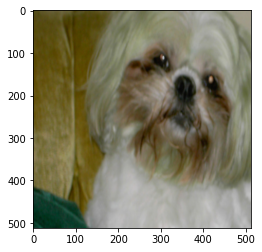

In [68]:
idx = 0
res = next(iter(valid_loader))
with torch.no_grad():
    out = model(torch.unsqueeze(res['image'][idx], 0).cuda())

img = res['image'][idx].detach().cpu().permute(1, 2, 0).numpy()
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
img = (img*std+mean)
img = img.copy()
plt.imshow(img)

print(f"Ground Truth: {res['label'][idx].item()}")
print(f'Predicted: {out.argmax().detach().cpu().item()}')

In [69]:
loss, _, acc, _, f1 = fitter.validation(valid_loader)
print(f'Mean Accuracy = {acc.avg:.3f}')
print(f'Mean F1 = {f1.avg:.3f}')
print(f'Mean Loss = {loss.avg:.3f}')

Val Step 981/982, summary_loss: 0.28693, time: 88.69333
Mean Accuracy = 0.935
Mean F1 = 0.929
Mean Loss = 0.287
